# Installations and libraries

In [ ]:
# Install Omnipath, Pypath and Decoupler
!pip install adjustText==0.8
!pip install git+https://github.com/saezlab/omnipath.git@v1.0.7
!pip install git+https://github.com/saezlab/decoupler-py.git@4b3978f

!pip install cvxpy>=1.3.2 git+https://github.com/saezlab/corneto.git@0.9.1-alpha.5

In [ ]:
# Clone the repository of the course
!git clone https://github.com/saezlab/PerMedCoE_tools_virtual_course_2023 permedcoe

Cloning into 'permedcoe'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 127 (delta 20), reused 14 (delta 5), pack-reused 89
Receiving objects: 100% (127/127), 45.76 MiB | 21.00 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [ ]:
from permedcoe.utils import (
    plot,
    get_problem_values,
    get_selected_edges_and_nodes,
    set_problem_value,
)

import omnipath as op
import decoupler as dc
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data handling

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Loading the data
dfc1 = pd.read_csv("./drive/MyDrive/OE33/data/Genes_OE33_METTL1_KO_AE4_vs_OE33_Control_AB1_edgeR_logFC_sorted.csv",).set_index('Unnamed: 0')
dfc2 = pd.read_csv("./drive/MyDrive/OE33/data/Genes_OE33_METTL1_KO_AB16_vs_OE33_Control_AB1_edgeR_logFC_sorted.csv").set_index('Unnamed: 0')
dfc3 = pd.read_csv("./drive/MyDrive/OE33/data/Genes_OE33_METTL1_KO_AE4_vs_OE33_Control_AE21_edgeR_logFC_sorted.csv").set_index('Unnamed: 0')
dfc4 = pd.read_csv("./drive/MyDrive/OE33/data/Genes_OE33_METTL1_KO_AB16_vs_OE33_Control_AE21_edgeR_logFC_sorted.csv").set_index('Unnamed: 0')
dfc5 = pd.read_csv("./drive/MyDrive/OE33/data/Genes_OE33_Control_AB1_vs_OE33_Control_AE21_edgeR_logFC_sorted.csv").set_index('Unnamed: 0')

dfc1['contrast'] = 'KO_AE4-Ctrl_AB1'
dfc2['contrast'] = 'KO_AB16-Ctrl_AB1'
dfc3['contrast'] = 'KO_AE4-Ctrl_AE21'
dfc4['contrast'] = 'KO_AB16-Ctrl_AE21'
dfc5['contrast'] = 'Ctrl_AB1-Ctrl_AE21'

dfc1.shape == dfc2.shape == dfc3.shape == dfc4.shape == dfc5.shape

True

In [ ]:
# Concatenate dataframes
combined_df = pd.concat([dfc1, dfc2, dfc3, dfc4, dfc5], ignore_index=True)

combined_df.head()

,gene_id,gene_name,logFC,logCPM,LR,PValue,FDR,contrast
0,ENSG00000223865,HLA-DPB1,-11.466551,3.186558,23.804345,0.000001,0.018144,KO_AE4-Ctrl_AB1
1,ENSG00000278996,ENSG00000278996,-10.651967,1.612660,11.791458,0.000595,0.037076,KO_AE4-Ctrl_AB1
2,ENSG00000009709,PAX7,10.481751,0.541444,10.276557,0.001347,0.044677,KO_AE4-Ctrl_AB1
3,ENSG00000288859,H2AC19,-10.232380,2.100471,10.593799,0.001135,0.042224,KO_AE4-Ctrl_AB1
4,ENSG00000167785,ZNF558,10.178492,1.065357,12.139305,0.000494,0.035338,KO_AE4-Ctrl_AB1


In [ ]:
combined_df.isnull().any()

gene_id      False
gene_name    False
logFC        False
logCPM       False
LR           False
PValue       False
FDR          False
contrast     False
dtype: bool

In [ ]:
combined_df.dtypes

gene_id       object
gene_name     object
logFC        float64
logCPM       float64
LR           float64
PValue       float64
FDR          float64
contrast      object
dtype: object

In [ ]:
# Simple volcano plot
#dc.plot_volcano_df(dfc1, x='logFC', y='PValue', top=20)

# TF activity inference

There are several databases that can be used, the newest one is ***collectri***, however in our analysis we will use the more classic database called ***Dorothea***:

In [ ]:
# collectri = op.interactions.CollecTRI.get(genesymbols=True)
# collectri
# col_tf = dc.omnip.get_collectri("human")
# col_tf

In [ ]:
dorothea_abc = dc.omnip.get_dorothea(levels = ('A', 'B', 'C'))
dorothea_abc

In [ ]:
df_differential_analysis = combined_df.pivot(index='contrast',
                                             columns='gene_name', values='logFC')
df_differential_analysis.head()

gene_name,A4GALT,AAAS,AACS,AADAC,AADACP1,AADAT,AAGAB,AAK1,AAMDC,AAMP,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
contrast,,,,,,,,,,,,,,,,,,,,,
Ctrl_AB1-Ctrl_AE21,-0.165380,0.244872,-0.136708,-2.125816,-1.283903,-0.597894,0.375820,0.201926,-0.296993,0.081239,...,-0.213243,0.334291,0.025847,0.118315,-0.140048,0.002480,-0.370379,-0.061080,-0.056398,0.098633
KO_AB16-Ctrl_AB1,-0.077757,0.450922,0.615918,0.118525,0.596570,0.078644,0.341130,-0.219537,-0.966838,0.193320,...,0.521154,0.649279,0.672986,-0.216610,-0.251731,0.045721,-0.004429,-0.179049,0.063451,-0.450343
KO_AB16-Ctrl_AE21,-0.243137,0.695794,0.479210,-2.007291,-0.687333,-0.519249,0.716950,-0.017610,-1.263831,0.274559,...,0.307911,0.983570,0.698833,-0.098295,-0.391780,0.048201,-0.374808,-0.240129,0.007053,-0.351711
KO_AE4-Ctrl_AB1,-0.415639,0.297329,0.365085,0.265490,0.930710,0.746338,0.236556,-0.262297,-0.954708,-0.162636,...,0.821311,0.605243,0.620764,-0.122757,0.145122,0.669170,0.148551,-0.074457,0.288144,0.196832
KO_AE4-Ctrl_AE21,-0.581019,0.542201,0.228376,-1.860325,-0.353193,0.148444,0.612375,-0.060371,-1.251701,-0.081397,...,0.608068,0.939534,0.646611,-0.004442,0.005074,0.671650,-0.221828,-0.135537,0.231746,0.295465


In [ ]:
dc.show_methods()

,Function,Name
0,run_aucell,AUCell.
1,run_consensus,Consensus score from top methods.
2,run_gsea,Gene Set Enrichment Analysis (GSEA).
3,run_gsva,Gene Set Variation Analysis (GSVA).
4,run_mdt,Multivariate Decision Tree (MDT).
5,run_mlm,Multivariate Linear Model (MLM).
6,run_ora,Over Representation Analysis (ORA).
7,run_udt,Univariate Decision Tree (UDT).
8,run_ulm,Univariate Linear Model (ULM).
9,run_viper,Virtual Inference of Protein-activity by Enric...


There are several statistical methods that can be used to infer a set of significantly active TFs (see the list in the table above and a full description in link below). Here, we will use a consensus of methods to get the most robust list of TFs.

[Methods description](https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/bioinformaticsadvances/2/1/10.1093_bioadv_vbac016/2/vbac016_supplementary_data.pdf?Expires=1710874321&Signature=SnKWcwXayU6o03TO~JItQ1rwcqYBx22nGkOoshuTuy1FNrVYDPyloLrpvG-fyWykhuueZoh6Crg3Kog2uNpejdGMlFWoRIZ8vO4viQfpT5GmiwLayvjcGs2QUQslqE1utVa4NJrsH4UJAVHLaEHTm5OfwvLMKMMnuRP6AJOFxc8eqcJZXRvyMcyQrLnCT6pBFwIWsKizz9bh8UIo5GKD-dylCL8kMa1SmzmTWD6XrNZwX~6J0SK~y5h~2TvOpU06XA18j2pP8w-Rqh0tkBMETnPpheCDJy8Rbux~7epYUjHalk23EEuhrSgyMO91frgNW8x9w-Il27sMVd9EYuoKhg__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA)

In [ ]:
tf_est_wmean, tf_est_wmean_norm, tf_est_wmean_norm, p_vals_wmean = dc.run_wmean(mat=df_differential_analysis,
                                     net=dorothea_abc, source='source',
                                     target='target', weight='weight',
                                     verbose=True)

tf_est_mlm, p_vals_mlm = dc.run_mlm(mat=df_differential_analysis,
                                     net=dorothea_abc, source='source',
                                     target='target', weight='weight',
                                     verbose=True)

tf_est_ulm, p_vals_ulm = dc.run_ulm(mat=df_differential_analysis,
                                     net=dorothea_abc, source='source',
                                     target='target', weight='weight',
                                     verbose=True)

tf_est_cons, p_vals_cons = dc.run_consensus(mat=df_differential_analysis,
                                     net=dorothea_abc, source='source',
                                     target='target', weight='weight',
                                     verbose=True)

Running wmean on mat with 5 samples and 17322 targets for 287 sources.
Infering activities on 1 batches.


100%|██████████| 1/1 [00:22<00:00, 22.89s/it]


Running mlm on mat with 5 samples and 17322 targets for 287 sources.


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Running ulm on mat with 5 samples and 17322 targets for 287 sources.
Running consensus.
Running mlm on mat with 5 samples and 17322 targets for 287 sources.


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Running ulm on mat with 5 samples and 17322 targets for 287 sources.
Running wsum on mat with 5 samples and 17322 targets for 287 sources.
Infering activities on 1 batches.


100%|██████████| 1/1 [00:19<00:00, 19.32s/it]


Results contain a tuple of four data frames:
1. raw weighted mean scores
2. their normalised version
3. multiple-testing corrected version
4. the p-values

We can plot the activity for each METTL1 knockout versus control contrast:

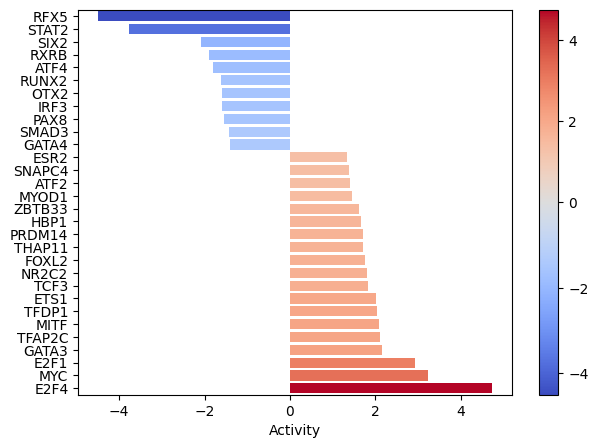

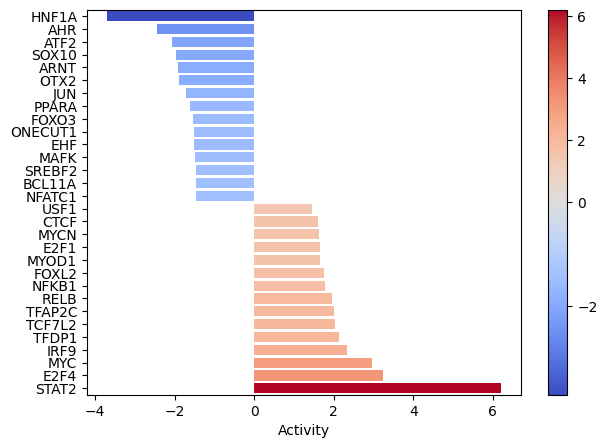

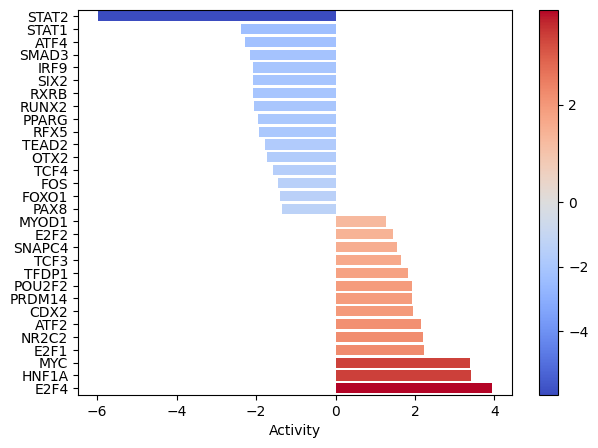

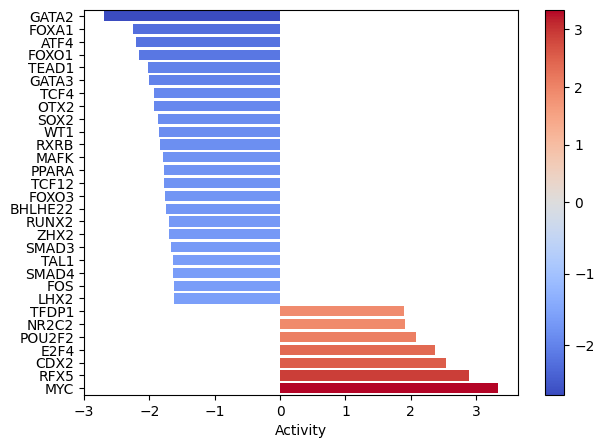

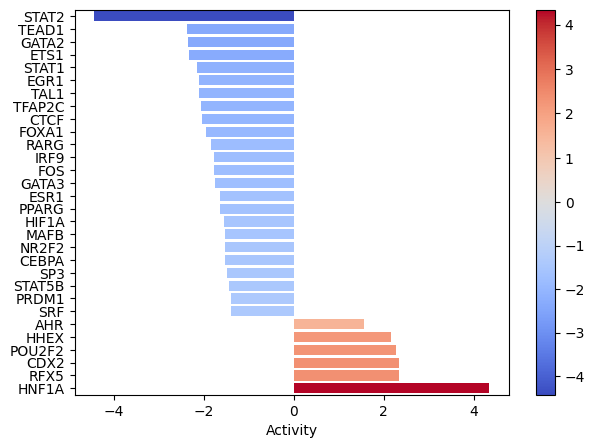

In [ ]:
for exp in ['KO_AE4-Ctrl_AB1', 'KO_AB16-Ctrl_AB1', 'KO_AE4-Ctrl_AE21',
            'KO_AB16-Ctrl_AE21', 'Ctrl_AB1-Ctrl_AE21']:
    dc.plot_barplot(tf_est_cons, exp, top=30, vertical=True)

Clustering by rows-samples:

In [ ]:
tf_est_cons_transp = tf_est_cons.T
tf_est_cons_transp

,Ctrl_AB1-Ctrl_AE21,KO_AB16-Ctrl_AB1,KO_AB16-Ctrl_AE21,KO_AE4-Ctrl_AB1,KO_AE4-Ctrl_AE21
AHR,1.556453,-2.449480,-0.390877,-0.817787,0.349504
AR,-0.860367,1.189943,0.166129,0.781902,-0.028881
ARID2,-0.102302,0.026164,-0.085170,0.813635,0.687170
ARID3A,-0.777615,-1.153386,-1.621146,-0.560009,-1.027882
ARNT,0.685764,-1.904374,-0.628463,0.196899,0.662650
...,...,...,...,...,...
ZNF584,-0.122546,0.265658,0.131441,0.405412,0.292206
ZNF592,-0.507165,0.446571,-0.100947,0.918050,0.450582
ZNF639,-0.101306,-0.406096,-0.363987,0.897495,0.814214
ZNF644,-0.453995,0.308741,-0.153575,0.801489,0.414608


In [2]:
# We can also use p_vals_cons, but since all of the values are quite large, probably this metric is not that relevant.

Selecting the most INactivated transcription factors in METTL1 KO - control contrasts compared to control-control contrast:

In [ ]:
# Calculating mean activity for all exp-ctrl comparisons
mean_rows = tf_est_cons.loc[['KO_AE4-Ctrl_AB1', 'KO_AB16-Ctrl_AB1', 'KO_AE4-Ctrl_AE21', 'KO_AB16-Ctrl_AE21']].mean()
# Sorting and selecting LOWEST activity
sorted_tfs = mean_rows.sort_values(ascending=True)

In [ ]:
condition_higher = (tf_est_cons_transp['KO_AE4-Ctrl_AB1'] > tf_est_cons_transp['Ctrl_AB1-Ctrl_AE21']) & \
                   (tf_est_cons_transp['KO_AB16-Ctrl_AB1'] > tf_est_cons_transp['Ctrl_AB1-Ctrl_AE21']) & \
                   (tf_est_cons_transp['KO_AE4-Ctrl_AE21'] > tf_est_cons_transp['Ctrl_AB1-Ctrl_AE21']) & \
                   (tf_est_cons_transp['KO_AB16-Ctrl_AE21'] > tf_est_cons_transp['Ctrl_AB1-Ctrl_AE21'])

condition_lower = (tf_est_cons_transp['KO_AE4-Ctrl_AB1'] < tf_est_cons_transp['Ctrl_AB1-Ctrl_AE21']) & \
                  (tf_est_cons_transp['KO_AB16-Ctrl_AB1'] < tf_est_cons_transp['Ctrl_AB1-Ctrl_AE21']) & \
                  (tf_est_cons_transp['KO_AE4-Ctrl_AE21'] < tf_est_cons_transp['Ctrl_AB1-Ctrl_AE21']) & \
                  (tf_est_cons_transp['KO_AB16-Ctrl_AE21'] < tf_est_cons_transp['Ctrl_AB1-Ctrl_AE21'])

filtered_rows_higher = tf_est_cons_transp[condition_higher]
filtered_rows_lower = tf_est_cons_transp[condition_lower]

filtered_rows_higher.shape

(141, 5)

In [ ]:
filtered_rows_lower.shape

(36, 5)

In [ ]:
# Universal colormap for all heatmaps
cmap = sns.diverging_palette(250, 10, center='light', as_cmap=True)
cmap.set_bad(color='white')

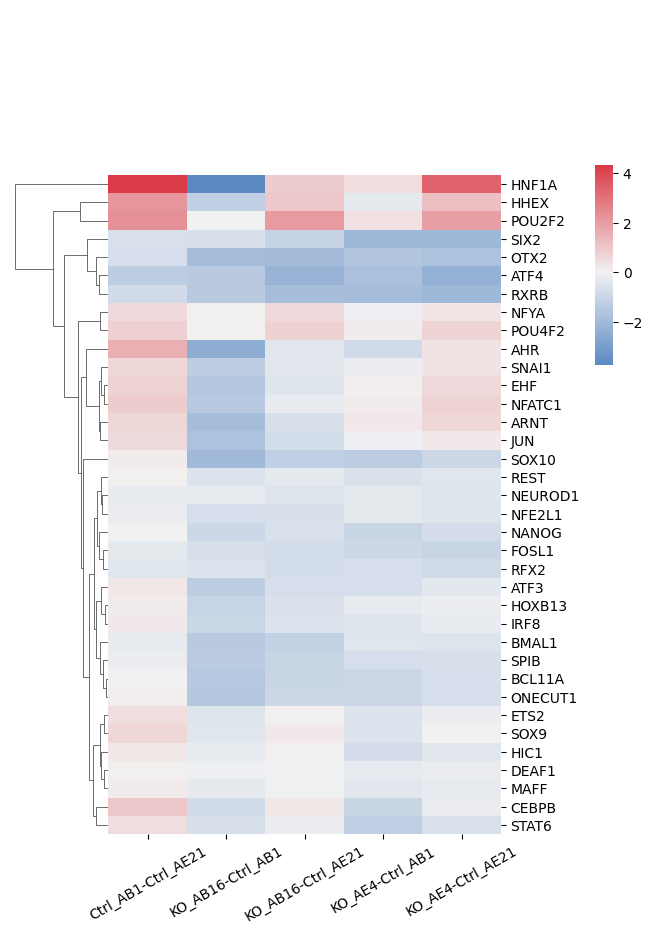

In [ ]:
# Clustermap without clustering by rows
clst = sns.clustermap(filtered_rows_lower, cmap=cmap, center=0, figsize=(6, 10),
                         col_cluster=False, cbar_kws={"orientation": "vertical"})
plt.gcf().axes[-1].set_position([1, 0.63, 0.03, 0.2])  # adjusting the legend position
plt.setp(clst.ax_heatmap.xaxis.get_majorticklabels(), rotation=30)
plt.show()

Selecting the most activated transcription factors in METTL1 KO - control contrasts compared to control-control contrast:

In [ ]:
# Calculating mean activity for all exp-ctrl comparisons
mean_values = filtered_rows_higher[['KO_AE4-Ctrl_AB1', 'KO_AB16-Ctrl_AB1', 'KO_AE4-Ctrl_AE21', 'KO_AB16-Ctrl_AE21']].mean(axis=1)
# Sorting and selecting HIGHEST POSITIVE activity
sorted_tfs = mean_values.sort_values(ascending=False)
# Selecting top-50
top_mean_act_tfs = sorted_tfs.head(50)
selected_tfs = filtered_rows_higher.loc[top_mean_act_tfs.index]
selected_tfs.head()

,Ctrl_AB1-Ctrl_AE21,KO_AB16-Ctrl_AB1,KO_AB16-Ctrl_AE21,KO_AE4-Ctrl_AB1,KO_AE4-Ctrl_AE21
E2F4,-0.833842,3.247593,2.375777,4.744378,3.948134
MYC,0.298277,2.973088,3.340313,3.236234,3.382840
TFDP1,-0.195039,2.121420,1.893579,2.049123,1.818979
E2F1,-0.694568,1.646155,0.809437,2.928934,2.231979
NR2C2,0.672938,1.299087,1.911020,1.801115,2.208170


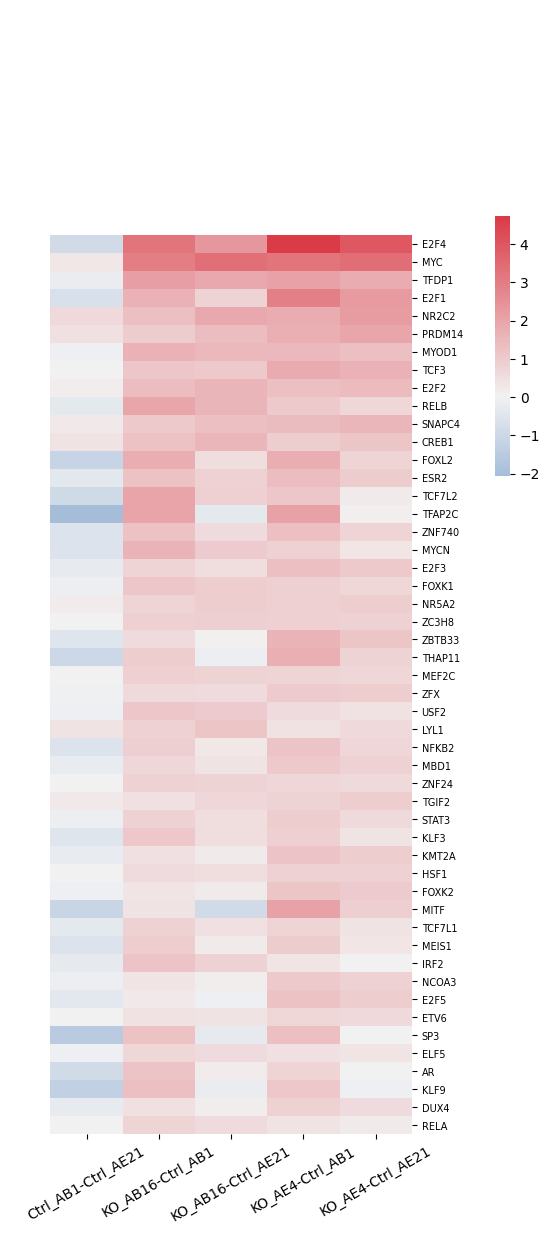

In [ ]:
# Clustermap without clustering by rows
cluster = sns.clustermap(selected_tfs, cmap=cmap, center=0, figsize=(5, 13),
                         col_cluster=False, row_cluster=False, cbar_kws={"orientation": "vertical"},
                         dendrogram_ratio=(0.1, 0.2))
plt.gcf().axes[-1].set_position([1, 0.63, 0.03, 0.2])  # Adjust position as needed
cluster.ax_heatmap.yaxis.set_tick_params(labelsize=7)  # Adjust the fontsize as needed
plt.setp(cluster.ax_heatmap.xaxis.get_majorticklabels(), rotation=30)
plt.show()

Without clustering by rows:

In [ ]:
mean_rows = tf_est_cons[['KO_AE4-Ctrl_AB1', 'KO_AB16-Ctrl_AB1', 'KO_AE4-Ctrl_AE21', 'KO_AB16-Ctrl_AE21']].mean(axis=1)
difference = tf_est_cons['Ctrl_AB1-Ctrl_AE21'] - mean_rows
sorted_tfs = difference.abs().sort_values(ascending=False)
top_variable_tfs = sorted_tfs.head(50)
selected_tfs = tf_est_cons.loc[:, top_variable_tfs]
cmap = sns.diverging_palette(250, 10, center='light', as_cmap=True)
cmap.set_bad(color='white')

sns.clustermap(selected_tfs, cmap=cmap, center=0, figsize=(15, 10))
plt.xticks(rotation=90)
plt.show()

Without clustering by rows-samples:

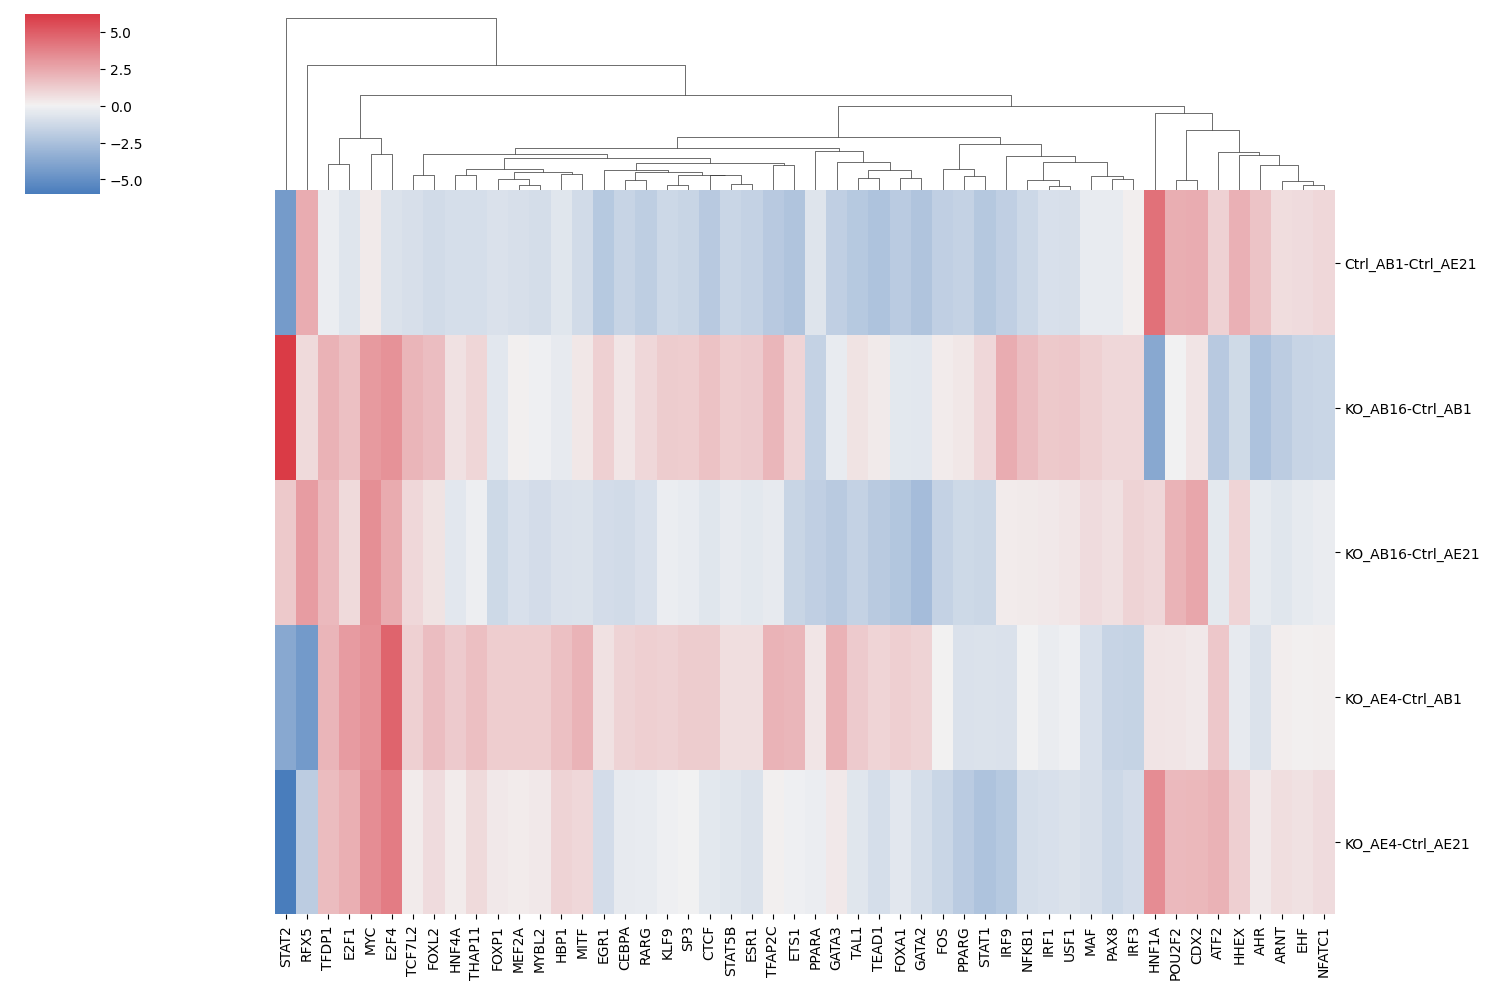

In [ ]:
top_variable_tfs = tf_est_cons.std(axis=0).sort_values().tail(50)
selected_tfs = tf_est_cons.loc[:, top_variable_tfs.index]
cmap = sns.diverging_palette(250, 10, center='light', as_cmap=True)
cmap.set_bad(color='white')
sns.clustermap(selected_tfs, cmap=cmap, center=0, figsize=(15, 10), row_cluster=False)
plt.xticks(rotation=90)
plt.show()